#  Breast Cancer Diagnosis via Logistic Regression

In this demo, we will see how to visualize training data for classification, plot the logistic function and perform logistic regression.  As an example, we will use the widely-used breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.

## Loading and Visualizing the Data

We first load the packages as usual.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline

Next, we load the data.  It is important to remove the missing values.

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
# na_values='?'的原因是，在这个数据里nan用？表示
df = df.dropna()
df.head(6)
# df.shape

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


After loading the data, we can create a scatter plot of the data labeling the class values with different colors.  We will pick two of the features.  

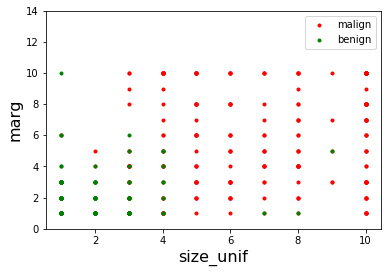

In [3]:
# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0)
Imal = (y==1)

# Get two predictors
xnames =['size_unif','marg'] 
X = np.array(df[xnames])

# Create the scatter plot
plt.plot(X[Imal,0],X[Imal,1],'r.')   #boolean类型的array也能用来选择矩阵的行or列数
plt.plot(X[Iben,0],X[Iben,1],'g.')
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')
# Iben[0:10]

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

One way to improve the plot is to draw circles on each point whose size is proportional to the count of samples at that point.  We will re-use this code, so we define a function. 

In [4]:
x0val = np.array(list(set(X[:,0]))).astype(float)   #不转换成list是size是1，转换成listsize是10
x1val = np.array(list(set(X[:,1]))).astype(float)
x0, x1 = np.meshgrid(x0val,x1val)
x0e= np.hstack((x0val,np.max(x0val)+1))  #从（10，）变成（11，）
x1e= np.hstack((x1val,np.max(x1val)+1))  #从（10，）变成（11，）

# Make a plot for each class
yval = list(set(y))
color = ['g','r']
for i in range(len(yval)):
    I = np.where(y==yval[i])[0]  #[0]取一维下标，[1]是二维下标（如果有的话）
    cnt, x0e, x1e = np.histogram2d(X[I,0],X[I,1],[x0e,x1e])

help(np.meshgrid)
'''
help(np.histogram2d)
H : ndarray, shape(nx, ny)
        The bi-dimensional histogram of samples `x` and `y`. Values in `x`
        are histogrammed along the first dimension and values in `y` are
        histogrammed along the second dimension.
    xedges : ndarray, shape(nx,)
        The bin edges along the first dimension.
    yedges : ndarray, shape(ny,)
        The bin edges along the second dimension.
'''

Help on function meshgrid in module numpy.lib.function_base:

meshgrid(*xi, **kwargs)
    Return coordinate matrices from coordinate vectors.
    
    Make N-D coordinate arrays for vectorized evaluations of
    N-D scalar/vector fields over N-D grids, given
    one-dimensional coordinate arrays x1, x2,..., xn.
    
    .. versionchanged:: 1.9
       1-D and 0-D cases are allowed.
    
    Parameters
    ----------
    x1, x2,..., xn : array_like
        1-D arrays representing the coordinates of a grid.
    indexing : {'xy', 'ij'}, optional
        Cartesian ('xy', default) or matrix ('ij') indexing of output.
        See Notes for more details.
    
        .. versionadded:: 1.7.0
    sparse : bool, optional
        If True a sparse grid is returned in order to conserve memory.
        Default is False.
    
        .. versionadded:: 1.7.0
    copy : bool, optional
        If False, a view into the original arrays are returned in order to
        conserve memory.  Default is True.  P

'\nhelp(np.histogram2d)\nH : ndarray, shape(nx, ny)\n        The bi-dimensional histogram of samples `x` and `y`. Values in `x`\n        are histogrammed along the first dimension and values in `y` are\n        histogrammed along the second dimension.\n    xedges : ndarray, shape(nx,)\n        The bin edges along the first dimension.\n    yedges : ndarray, shape(ny,)\n        The bin edges along the second dimension.\n'

<module 'matplotlib.pyplot' from '/Users/Lovely-white/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

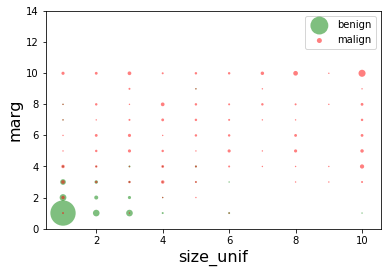

In [5]:
def plot_cnt(X,y):
    
    # Compute the bin edges for the 2d histogram
    x0val = np.array(list(set(X[:,0]))).astype(float)   #不转换成list是size是1，转换成listsize是10
    x1val = np.array(list(set(X[:,1]))).astype(float)
    x0, x1 = np.meshgrid(x0val,x1val)
    x0e= np.hstack((x0val,np.max(x0val)+1))  #从（10，）变成（11，）
    x1e= np.hstack((x1val,np.max(x1val)+1))  #从（10，）变成（11，）

    # Make a plot for each class
    yval = list(set(y))
    color = ['g','r']
    for i in range(len(yval)):
        I = np.where(y==yval[i])[0]  #[0]取一维下标，[1]是二维下标（如果有的话）
        cnt, x0e, x1e = np.histogram2d(X[I,0],X[I,1],[x0e,x1e]) #bins是指频数（直方图高度）
        x0, x1 = np.meshgrid(x0val,x1val)
        plt.scatter(x0.ravel(), x1.ravel(), s=2*cnt.ravel(),alpha=0.5,   #ravel()降维 flattern（）拷贝降维
                    c=color[i],edgecolors='none')
    plt.ylim([0,14])
    plt.legend(['benign','malign'], loc='upper right')
    plt.xlabel(xnames[0], fontsize=16)
    plt.ylabel(xnames[1], fontsize=16)
    return plt

plot_cnt(X,y)

## In-Class Exercise

Based on the above plot, what would be a good "classifer" using the two features.  That is, write a function that makes a prediction `yhat` of the class label `y`.  Code up your classifier function.  Measure the accuracy of the classifier on the data.  What percentage error does your classifier get?

In [6]:
# TODO

## Some Simple Classification ideas

Here are some ideas for classification that you may have already thought of.  We can see that the benign samples are located in the lower left.  So, one simple classification rule is to define the region with a line.  We plot the region for one possible line with the following code.

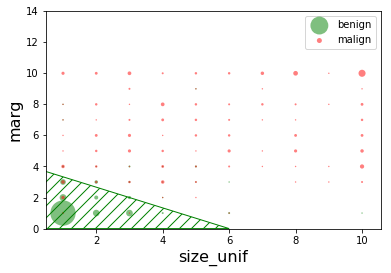

In [7]:
from matplotlib import patches
plt = plot_cnt(X,y)

ax = plt.gca() 
ax.add_patch(
    patches.Polygon([[0,0],[0,4],[6,0]],
        color='green',
        fill=False, hatch = '//'
    )
)

Here is an alternate classification rule based on two linear constraints.

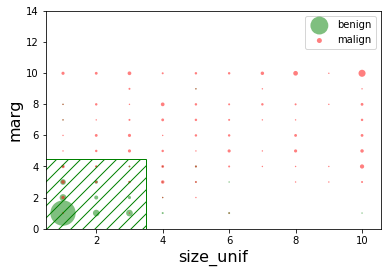

In [8]:
plt = plot_cnt(X,y)
ax = plt.gca()
ax.add_patch(
    patches.Rectangle(
        (0, 0),   # (x,y)
        width=3.5, height=4.5,  color='green',
        fill=False, hatch = '//'
    )
)

## Logistic Functions


This demo illustrate an important classifier known as *logistic regression*.  In logistic regression, we do not just output an estimate of the class label, `yhat`.  Instead, we ouput a *probability*, an estimate of how likely the sample is one class or the other.  That is our output is a number from 0 to 1 representing the likelihood:
$$
    P(y = 1|x)
$$
which is our estimate of the probability that the sample is one class (in this case, a malignant sample) based on the features `x`.  This is sometimes called a *soft classifier*.  

In logistic regression, we assume that likelihood is of the form
$$
    P(y=1|x) = f(z),  \quad z = w_0 + w_1x_1 + \cdots + w_kx_k,  
$$
where $w_0,\ldots,w_k$ are the classifier weights and $f(z) is the so-called *logistic* function:
$$
    f(z) = \frac{1}{1+e^{-z}}.
$$

To understand the logistic function, suppose $x$ is a scalar and samples $y$ are drawn with $P(y=1|x) = f(w_1x)$ fro some scaling $w_1$.  We plot these samples for different $w_1$.

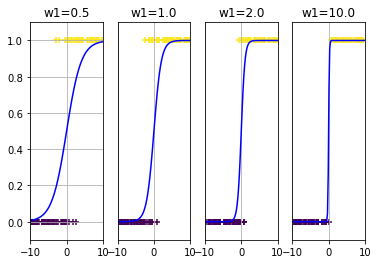

In [9]:
nx = 100
xm = 10
w1s = np.array([0.5,1,2,10])
nplot = w1s.size
iplot = 0
for w1 in w1s:
    iplot += 1
    x  = np.random.uniform(-xm,xm,nx)
    plt.subplot(1,nplot,iplot)
    py = 1/(1+np.exp(-w1*x))
    yp = np.array(np.random.rand(nx) < py)
    xp = np.linspace(-xm,xm,100)
    pyp = 1/(1+np.exp(-w1*xp))

    plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')
    plt.plot(xp,pyp,'b-')
    plt.axis([-xm,xm,-0.1,1.1])
    plt.grid()
    if (iplot > 1):
        plt.yticks([])
    plt.xticks([-10,0,10])
    plt.title('w1={0:.1f}'.format(w1))


We see that $f(w_1x)$ represents the probability that $y=1$.  The function $f(w_1x) > 0.5$ for $x>0$ meaning the samples are more likely to be $y=1$.  Similarly, for $x<0$, the samples are more likely to $y=0$.  The scaling $w_1$ determines how fast that transition is.

## Fitting the Logistic Model

In a logistic model, we must fit the weights $w_0,w_1,\ldots,w_k$ in the model 
$$
    P(y=1|x) = f(z),  \quad z = w_0 + w_1x_1 + \cdots + w_kx_k,  
$$
The `sklearn` module has very good routines for fitting this model.  First we get the training data and samples.  We will standardize the `X` values to make more sense of the slope values.

In [10]:
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
X = np.array(df[xnames])
Xs = preprocessing.scale(X)

Next, we create a logistic regression object.  The parameter `C` states the level of regularization and will be discussed in class.

In [11]:
logreg = linear_model.LogisticRegression(C=1e5)

Then, we fit the model.

In [12]:
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

We can next plot the accuracy on the training data.  We see we get over 96%.

In [13]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.969253


It is also useful to print the weights for each feature.  We can use the `pandas` package to make a table.

In [14]:
data = {'feature': xnames, 'slope': np.squeeze(logreg.coef_)}
dfslope = pd.DataFrame(data=data)
dfslope

,feature,slope
0,thick,1.508834
1,size_unif,-0.015979
2,shape_unif,0.957072
3,marg,0.947234
4,cell_size,0.214964
5,bare,1.395001
6,chrom,1.095654
7,normal,0.650696
8,mit,0.925912


## Cross-Validation

The above code measured the accuracy on the training data.  However, we should measure the accuracy on test data.  We perform 4-fold cross-validation and print average precision, recall, f1-score and accuracy.


In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 4
kf = KFold(n_splits=nfold)
prec = []
rec = []
f1 = []
acc = []
for train, test in kf.split(Xs):            
    # Get training and test data
    Xtr = Xs[train,:]
    ytr = y[train]
    Xts = Xs[test,:]
    yts = y[test]
    
    # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary') 
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)

# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)

# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)

print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall =    {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 =        {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy =  {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

Precision = 0.9614, SE=0.0164
Recall =    0.9554, SE=0.0232
f1 =        0.9578, SE=0.0150
Accuracy =  0.9664, SE=0.0136


## ROC curve

As discussed above, the logistic classifier outputs a *soft* classification $P(y=1|x)$.  One simple idea is to select the class label $\hat{y}=1$ whenever $P(y=1|x) > 0.5$.  However, one can also set $\hat{y}=1$ whenever $P(y=1|x) > t$ for some threshold $t$.  Using higher thresholds values selects $\hat{y}=0$ more often which results in fewer *false alarms*.  Similarly, lower thresholds values selects $\hat{y}=1$ more often which results in fewer *missed detections*.  The ROC curve displays this  tradeoff by graphing the *true positive rate* vs. *false positive rate*.  

The ROC curve can be plotted in the `sklearn` package with the following code.

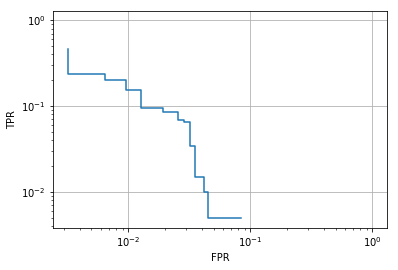

In [16]:
from sklearn import metrics
yprob = logreg.predict_log_proba(Xtr)
fpr, tpr, thresholds = metrics.roc_curve(ytr,yprob[:,1])

plt.loglog(fpr,1-tpr)
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')

In [18]:
logreg.intercept_

array([-0.98986529])